In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import scqubits
from functools import partial
import qutip
import concurrent
from loky import get_reusable_executor
import numpy as np
import qutip
import scqubits
from typing import List, Union,Any

from CoupledQuantumSystems.qobj_manip import *
from CoupledQuantumSystems.drive import *
from CoupledQuantumSystems.evo import ODEsolve_and_post_process
from CoupledQuantumSystems.noise import *
from CoupledQuantumSystems.qobj_manip import *
from CoupledQuantumSystems.IFQ import gfIFQ


In [3]:
from scipy.optimize import minimize

EJ = 4
EC = EJ/2.7
EL = EJ/45

qbt = gfIFQ(EJ = EJ,EC =EC,EL = EL,truncated_dim=13)

temp_in_mK = 10
loss_tangent_ref = 1e-6
one_over_f_flux_noise_amplitude = 1e-6

c_ops=qbt.get_T1_c_ops(temp_in_mK,
                        loss_tangent_ref,
                        one_over_f_flux_noise_amplitude)
e_ops = [qutip.ket2dm(qutip.basis(qbt.truncated_dim, i)) for i in range(12)]


 /tmp/ipykernel_891473/1980754626.py: 38

In [11]:
from IPython.display import clear_output

t_duration = 50
tlist = np.linspace(0,t_duration,int(t_duration*5))
detuning = 0.3

# compute the fidelity

In [12]:
state_0_dressed = qutip.basis(qbt.truncated_dim, 0)
state_1_dressed = qutip.basis(qbt.truncated_dim, 2)
state_plus_X_dressed = (state_0_dressed +  state_1_dressed).unit()
state_minus_X_dressed = (state_0_dressed - state_1_dressed).unit()
state_plus_Y_dressed = (state_0_dressed + 1j * state_1_dressed).unit()
state_minus_Y_dressed = (state_0_dressed - 1j * state_1_dressed).unit()

initial_states  = [
                   state_0_dressed,
                   state_1_dressed,
                   state_plus_X_dressed,
                   state_minus_X_dressed,
                   state_plus_Y_dressed,
                   state_minus_Y_dressed
                   ]

x = [2.18589999, 2.16294093, 0.30230657, 0.30234735]

amp1_scaling_factor = x[0]
amp2_scaling_factor = x[1]
detuning1 =x[2]
detuning2 =x[3]
results  = qbt.run_qutip_mesolve_parrallel(
    initial_states = initial_states,
    tlist = tlist,
    drive_terms = qbt.get_Raman_DRAG_drive_terms(
        i = 0,
        j = 3,
        k = 2,
        detuning1=detuning1,
        detuning2 = detuning2,
        t_duration=t_duration,
        shape='sin^2',
        amp_scaling_factor = 1,
        amp1_scaling_factor = amp1_scaling_factor,
        amp2_scaling_factor = amp2_scaling_factor,
        amp1_correction_scaling_factor = 0,
        amp2_correction_scaling_factor = 0,
    ),
    c_ops = c_ops,
    e_ops = e_ops
)


 Total run time:   0.72s*] Elapsed 0.72s / Remaining 00:00:00:00 [*********94%********** ] Elapsed 0.71s / Remaining 00:00:00:00
 Total run time:   0.75s*] Elapsed 0.75s / Remaining 00:00:00:00 [*********96%********** ] Elapsed 0.75s / Remaining 00:00:00:00
 Total run time:   0.75s*] Elapsed 0.75s / Remaining 00:00:00:00 [*********97%********** ] Elapsed 0.75s / Remaining 00:00:00:00
 Total run time:   0.74s*] Elapsed 0.74s / Remaining 00:00:00:00
 Total run time:   0.77s*] Elapsed 0.77s / Remaining 00:00:00:00
 Total run time:   0.81s*] Elapsed 0.81s / Remaining 00:00:00:00


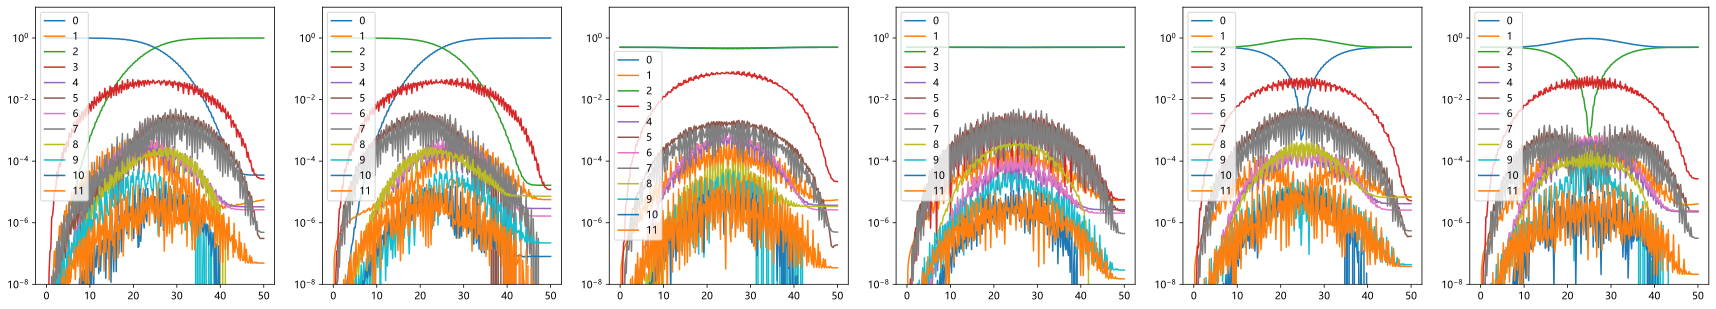

In [13]:
fig, axes = plt.subplots(1,6,figsize = (30,5))
for i, (result,ax) in enumerate(zip(results,axes)):
    for i, exp in enumerate(result.expect):
        ax.plot(tlist,exp,label= f"{i}")
    ax.legend()
    ax.set_yscale('log')
    ax.set_ylim(1e-8,1e1)

In [14]:

def truncate_to_computational(state,i,j):
    if state.isket:
        state = qutip.ket2dm(state)
    arr = state.full()
    arr= arr[[i, j], :][:, [i, j]]
    dm = qutip.Qobj(arr)
    dm = dm/dm.tr()
    return dm
zero = qutip.basis(2, 0)
one = qutip.basis(2, 1)
states_ideal  = [zero,
                one,
                (zero +  one).unit(),
                (zero - one).unit(),
                (zero + 1j * one).unit(),
                (zero - 1j *one).unit()]

states_ideal_after_gate = []
for state in states_ideal:
    states_ideal_after_gate.append(qutip.qip.operations.x_gate() * state)


def calc_average_fidelity_with_phase(phase,dms,states_ideal_after_gate):
    gate = qutip.qip.operations.phasegate(phase)
    fid=[]
    for dm,ket_ideal in zip(dms,states_ideal_after_gate):
        fid.append(qutip.fidelity(gate*dm*gate.dag(), ket_ideal))
    return 1-sum(fid)/len(fid)


from scipy.optimize import minimize
dms = [truncate_to_computational(result.states[-1], 0,2) for result in results]
def objective_function(phase):
    return calc_average_fidelity_with_phase(phase[0], dms, states_ideal_after_gate)
opt_result = minimize(objective_function,x0=  [0],bounds = [(0, 2*np.pi)], method="Powell")
print(f"infidelity: {opt_result.fun}, phase {opt_result.x[0]}")

infidelity: 1.4897006767711218e-05, phase 4.352435830809179


In [15]:
gate = qutip.qip.operations.phasegate(4.352403649482513)
for dm,ket_ideal in zip(dms,states_ideal_after_gate):
    print(qutip.fidelity(gate*dm*gate.dag(), ket_ideal))

0.9999824041041709
0.9999917561605339
0.9999715069113422
0.999995150260677
0.9999816091360099
0.9999881908135801


In [16]:

def get_leakage_trace(state,i,j):
    if state.isket:
        state = qutip.ket2dm(state)
    arr = state.full()
    arr= arr[[i, j], :][:, [i, j]]
    dm = qutip.Qobj(arr)
    return 1-dm.tr()

leakage_list = [get_leakage_trace(result.states[-1], 0,2) for result in results]

In [17]:
leakage_list

[3.6541912132093124e-05,
 2.3757561319892595e-05,
 3.782882227443274e-05,
 1.7677444470676207e-05,
 2.6522360238256937e-05,
 3.3349197253951246e-05]